In [1]:
import dynamo as dyn
import scanpy as sc
import matplotlib.pyplot as plt 

import squidpy

import pysal

import cv2

import numpy as np 
import pandas as pd 
%matplotlib inline

In [2]:
# adata = dyn.read_h5ad("zebrafish_tutorial.h5ad")
adata = dyn.sample_data.zebrafish()
dyn.pp.recipe_monocle(adata) # , exprs_frac_max=0.005)
dyn.tl.dynamics(adata, model='stochastic', cores=3) 

|-----> apply Monocole recipe to adata...
/Users/mashiro/anaconda3/envs/dynamo-dev/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['pp'] in AnnData Object.
|-----------> <insert> experiment_type to uns['pp'] in AnnData Object.
|-----> filtering cells...
|-----> filtering ge

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'use_for_pca', 'frac', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'dynamics'
    obsm: 'X_pca', 'X'
    layers: 'spliced', 'unspliced', 'X_spliced', 'X_unspliced', 'M_u', 'M_uu', 'M_s', 'M_us', 'M_ss', 'velocity_S'
    obsp: 'moments_con'

In [3]:
dyn.tl.reduceDimension(adata)
dyn.tl.cell_velocities(adata, method='pearson', other_kernels_dict={'transform': 'sqrt'})
# dyn.vf.VectorField(adata, basis='pca', M=1000, pot_curl_div=True) 

calculating transition matrix via pearson kernel with sqrt transform.: 100%|██████████| 4181/4181 [00:12<00:00, 323.95it/s]
projecting velocity vector to low dimensional embedding...: 100%|██████████| 4181/4181 [00:01<00:00, 3999.90it/s]


AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'use_for_pca', 'frac', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap'
    obsm: 'X_pca', 'X', 'X_umap', 'velocity_umap'
    layers: 'spliced', 'unspliced', 'X_spliced', 'X_unspliced', 'M_u', 'M_uu', 'M_s', 'M_us', 'M_ss', 've

<Figure size 400x400 with 0 Axes>

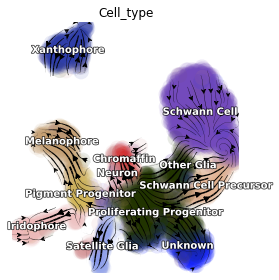

In [4]:
dyn.pl.streamline_plot(adata, color=['Cell_type'], basis='umap', show_legend='on data', 
                       quiver_length=6, quiver_size=6,  show_arrowed_spines=False,
                       figsize=(4, 4))

<Figure size 400x400 with 0 Axes>

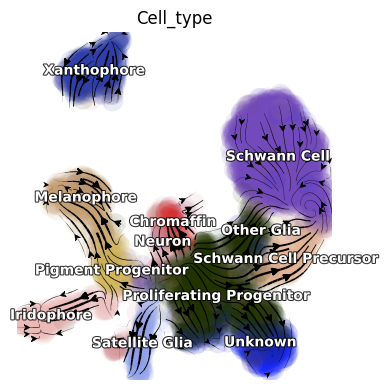

<Figure size 400x400 with 0 Axes>

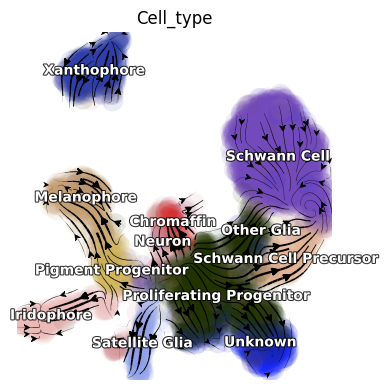

<Figure size 400x400 with 0 Axes>

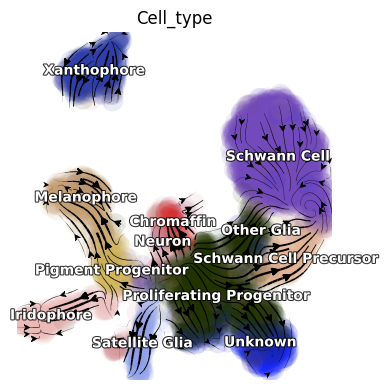

In [5]:
dyn.pl.streamline_plot(adata, color=['Cell_type'], basis='umap', show_legend='on data', 
                       quiver_length=6, quiver_size=6,  show_arrowed_spines=False,
                       figsize=(4, 4)
                      )
dyn.pl.streamline_plot(adata, color=['Cell_type'], basis='umap', show_legend='on data', 
                       quiver_length=6, quiver_size=6,  show_arrowed_spines=False,
                       figsize=(4, 4)
                      )
dyn.pl.streamline_plot(adata, color=['Cell_type'], basis='umap', show_legend='on data', 
                       quiver_length=6, quiver_size=6,  show_arrowed_spines=False,
                       figsize=(4, 4)
                      )

In [6]:
adata.var.use_for_transition.sum()

516

## Vector field analysis
In this part we will go through how to utilize Dynamo to do vector field analysis.
The big picture is to compute Jacobian, acceleration, and curvature information to rank genes across all cells or in each cell group, followed by gene set enrichment analysis and regulatory network construction and visualization.


Here again Here we can choose a few genes from figure 3 (si 5) of Saunders, et al (2019) to see their expression dynamics over time. 

In [7]:
fig3_si5 = ['mitfa', 'pax3a', 'tfec', 'dct', 'alx4b', 'tyrp1b', 'gpnmb', 'pmela', 'pnp4a']
# all_genes = adata.var_names
all_genes = fig3_si5

Calculate cell velocities in PCA space.

In [8]:
dyn.tl.cell_velocities(adata, basis='pca')

projecting velocity vector to low dimensional embedding...:   5%|▌         | 225/4181 [00:00<00:01, 2249.71it/s]

Using existing pearson_transition_matrix found in .obsp.


projecting velocity vector to low dimensional embedding...: 100%|██████████| 4181/4181 [00:01<00:00, 2787.95it/s]


AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'use_for_pca', 'frac', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap', 'grid_velocity_pca'
    obsm: 'X_pca', 'X', 'X_umap', 'velocity_umap', 'velocity_pca'
    layers: 'spliced', 'unspliced', 'X_spliced', 'X_unspliced', 'M_u

Here the `dyn.vf.VectorField` function learns a function of high dimensional vector field from sparse single cell samples in the entire space robustly. Learned vector field related information fields are inserted to adata. You can try different methods to learn the vector field by changing the method parameter.

In [9]:
dyn.vf.VectorField(adata, basis='pca', M=100, method = "SparseVFC")

|-----> vectorfield calculation begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> <insert> velocity_pca_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_pca_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_pca to uns in AnnData Object.
|-----> <insert> control_point_pca to obs in AnnData Object.
|-----> <insert> inlier_prob_pca to obs in AnnData Object.
|-----> <insert> obs_vf_angle_pca to obs in AnnData Object.

|-----> VectorField finished [0.2327s]


Here we use `dyn.vf.curvature` to calculate curvature for each cell with the reconstructed vector field function stored in adata. `dyn.vf.rank_curvature_genes` ranks genes based on their absolute curvature values in different cell groups.

In [10]:
dyn.vf.curvature(adata, basis='pca')

Calculating curvature: 100%|██████████| 4181/4181 [00:00<00:00, 40100.03it/s]


In [11]:
dyn.vf.rank_curvature_genes(adata, groups='Cell_type')

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'curvature_pca'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'use_for_pca', 'frac', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap', 'grid_velocity_pca', 'VecFld_pca', 'rank_curvature', 'rank_abs_curvature'
   

`dyn.vf.acceleration` is used here to compute acceleration for each cell with the learned vector field in adata. Note that we use PCA basis to calculate acceleration, but `dyn.vf.acceleration` will project acceleration_pca back to high dimension version for each gene. You can check the resulted adata having both acceleration and acceleration_pca. We then rank acceleration in the same fashion as what we did to curvature.

In [12]:
dyn.vf.acceleration(adata, basis='pca')

Calculating acceleration: 100%|██████████| 4181/4181 [00:00<00:00, 51729.60it/s]


In [13]:
dyn.vf.rank_acceleration_genes(adata, groups='Cell_type')

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'curvature_pca', 'acceleration_pca'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'use_for_pca', 'frac', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap', 'grid_velocity_pca', 'VecFld_pca', 'rank_curvature', 'ran

Use `dyn.pp.top_pca_genes` to calculate "top_pca_genes" for adata, according to PCs in `adata.uns`.

In [14]:
dyn.pp.top_pca_genes(adata)

484 top PCA genes found for 30 PCs.


AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'curvature_pca', 'acceleration_pca'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'use_for_pca', 'frac', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition', 'top_pca_genes'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap', 'grid_velocity_pca', 'VecFld_pca', 'rank

In [15]:
top_pca_genes = adata.var.index[adata.var.top_pca_genes]

Here we calculate Jacobian for each cell with the reconstructed vector field. If we use some kind of reduced dimension such as PCA space, `dyn.vf.jacobian` will project the low dimension Jacobian results back to high dimension as we can check in the resulted adata object.

In [16]:
dyn.vf.jacobian(adata, regulators=top_pca_genes, effectors=top_pca_genes)

/Users/mashiro/anaconda3/envs/dynamo-dev/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Transforming subset Jacobian: 100%|██████████| 4181/4181 [00:23<00:00, 180.19it/s]
/Users/mashiro/dynamo-release/dynamo/vectorfield/vector_calculus.py:307: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["jacobian_det_" + basis][cell_idx] = Js_det


AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'curvature_pca', 'acceleration_pca', 'jacobian_det_pca'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'use_for_pca', 'frac', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition', 'top_pca_genes'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap', 'grid_velocity_pca',

Rank genes based on their diagonal Jacobian for each cell group. The "divergence" we are talking about here is basically the diagonal elements of the Jacobian, i.e. the self-activation\inhibition terms. The results are stored in `adata.uns['rank_div_gene_jacobian_pca']`.  
Run `dyn.vf.jacobian` before using this function.

In [17]:
divergence_rank = dyn.vf.rank_divergence_genes(adata, groups='Cell_type')

We can check the result of `dyn.vf.rank_divergence_genes`

In [18]:
divergence_rank.head(10)

Chromaffin         Iridophore        Melanophore             Neuron  \
0               mdka                mt2               sdc4               gfap   
1               gfap             tyrp1b               fosb  si:ch211-251b21.1   
2  si:ch211-251b21.1              pmela            tspan36               mdka   
3               mdkb              ptmab              ptmaa               mdkb   
4   si:ch211-39i22.1             cldn19             tubb4b             cldn19   
5             entpd1              tubb5               rgcc  si:ch211-222l21.1   
6              sparc  si:ch211-251b21.1              crip1                mt2   
7             mmp17b               gfap  si:ch211-251b21.1   si:ch211-39i22.1   
8   si:ch211-132g1.3               gch2               gfap              sparc   
9              fstl3              ptmaa              mcl1a             atp1b4   

         Other Glia Pigment Progenitor Proliferating Progenitor  \
0            tyrp1b             tyrp1b                   cldn19   
1             pmela                mt2                    ptmab   
2             pnp4a              pmela                    tubb5   
3             fhl2a  si:ch211-251b21.1                    ptmaa   
4             tubb5              ptmab        si:ch211-251b21.1   
5           lgals2a             cldn19                    fstl3   
6             CRIP2              pnp4a                     mdka   
7            cldn19  si:ch211-222l21.1                   entpd1   
8  si:ch211-39i22.1               gfap                   pmp22a   
9              qki2              tubb5                   elavl4   

      Satellite Glia      Schwann Cell Schwann Cell Precursor  \
0               gfap             plp1b      si:ch211-251b21.1   
1  si:ch211-222l21.1            tyrp1b                 tyrp1b   
2              tubb5             pmela                   mdka   
3             pmp22a             pnp4a                  pmela   
4             cldn19             fhl2a                 dynll1   
5              ptmaa            elavl4                   gfap   
6              sox4a             CRIP2                  pnp4a   
7             elavl4  si:ch211-39i22.1                 elavl4   
8                mt2           lgals2a                   mdkb   
9              grasp             rtn1b       si:ch211-39i22.1   

            Unknown        Xanthophore  
0            cldn19               sdc4  
1             fstl3  si:ch211-251b21.1  
2             ptmaa             tyrp1b  
3             ptmab            tspan36  
4             egr2b         wu:fc46h12  
5  si:ch211-132g1.3              pmela  
6             sox4a               rgcc  
7             tubb5              ptmaa  
8  si:ch211-39i22.1             gpm6ab  
9              qki2   si:ch211-39i22.1

We can also rank all other elements in the Jacobian.   
There are 5 parameters we provide in `dyn.vf.rank_jacobian_genes`'s argument list to rank the Jacobian:

* "full reg": top regulators are ranked for each effector for each cell group

* "full eff": top effectors are ranked for each regulator for each cell group

* "reg": top regulators in each cell group

* "eff": top effectors in each cell group

* "int": top effector-regulator pairs in each cell group

Note that the default mode is "full reg".

In [19]:
full_reg_rank = dyn.vf.rank_jacobian_genes(adata, groups='Cell_type', mode="full reg", abs=True, output_values=True)

rank = full_reg_rank[list(full_reg_rank.keys())[0]]

In [20]:
full_eff_rank = dyn.vf.rank_jacobian_genes(adata, groups='Cell_type', mode='full eff', abs=True, exclude_diagonal=True, output_values=True)

In [21]:
eff_rank = dyn.vf.rank_jacobian_genes(adata, groups='Cell_type', mode='eff', abs=True, output_values=True)

In [22]:
reg_rank = dyn.vf.rank_jacobian_genes(adata, groups='Cell_type', mode='reg', abs=True, exclude_diagonal=True)

In [23]:
int_rank = dyn.vf.rank_jacobian_genes(adata, groups='Cell_type', mode='int', exclude_diagonal=True, output_values=True)

Save results to the current workspace.

In [24]:
import pickle
pickle.dump(adata.uns['rank_acceleration'], open('./zebrafish_vf_rank_acceleration.p', 'wb'))
pickle.dump(adata.uns['rank_curvature'], open('./zebrafish_vf_rank_curvature.p', 'wb'))

pickle.dump(adata.uns['rank_abs_acceleration'], open('./zebrafish_vf_rank_abs_acceleration.p', 'wb'))
pickle.dump(adata.uns['rank_abs_curvature'], open('./zebrafish_vf_rank_abs_curvature.p', 'wb'))

adata.uns['rank_acceleration'].to_csv('zebrafish_vf_rank_acceleration.csv')
adata.uns['rank_curvature'].to_csv('zebrafish_vf_rank_curvature.csv')
adata.uns['rank_abs_acceleration'].to_csv('zebrafish_vf_rank_abs_acceleration.csv')
adata.uns['rank_abs_curvature'].to_csv('zebrafish_vf_rank_abs_curvature.csv')

pickle.dump(divergence_rank, open('./zebrafish_vf_divergence_rank.p', 'wb'))

pickle.dump(full_reg_rank, open('./zebrafish_vf_full_reg_rank.p', 'wb'))
pickle.dump(full_eff_rank, open('./zebrafish_vf_full_eff_rank.p', 'wb'))
pickle.dump(rank, open('./zebrafish_vf_rank.p', 'wb'))
pickle.dump(eff_rank, open('./zebrafish_vf_eff_rank.p', 'wb'))
pickle.dump(reg_rank, open('./zebrafish_vf_reg_rank.p', 'wb'))
pickle.dump(int_rank, open('./zebrafish_vf_int_rank.p', 'wb'))

pickle.dump(divergence_rank, open('./zebrafish_vf_divergence_rank.p', 'wb'))

pickle.dump(full_reg_rank, open('./zebrafish_vf_full_reg_rank.p', 'wb'))
pickle.dump(full_eff_rank, open('./zebrafish_vf_full_eff_rank.p', 'wb'))
pickle.dump(rank, open('./zebrafish_vf_rank.p', 'wb'))
pickle.dump(eff_rank, open('./zebrafish_vf_eff_rank.p', 'wb'))
pickle.dump(reg_rank, open('./zebrafish_vf_reg_rank.p', 'wb'))
pickle.dump(int_rank, open('./zebrafish_vf_int_rank.p', 'wb'))

int_rank = pickle.load(open('./zebrafish_vf_int_rank.p', 'rb'))
reg_rank = pickle.load(open('./zebrafish_vf_reg_rank.p', 'rb'))

-----------TODO TUTORIAL EXPLANATION PART BELOW-----------

In [25]:
# int_rank.head(50)
print(type(rank))
print(type(full_eff_rank))
print(type(int_rank))
print(type(reg_rank))

<class 'pandas.core.frame.DataFrame'>
<class 'dict'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


Now we can check the top regulators for each marker gene in each cell type. This is the same when the ranking results is based on full ranking (`full reg` or `full eff`)

In [26]:
rank.columns.intersection(all_genes)

Index(['tfec', 'tyrp1b', 'pmela', 'pnp4a', 'gpnmb', 'dct'], dtype='object')

### Build Regulatory Network

In [27]:
edges_list = dyn.vf.build_network_per_cluster(adata,
                                              cluster='Cell_type',
                                              cluster_names=None,
                                              full_reg_rank=full_reg_rank,
                                              full_eff_rank=full_eff_rank,
                                              genes=all_genes,
                                              n_top_genes=100)

import networkx as nx


/Users/mashiro/anaconda3/envs/dynamo-dev/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/mashiro/anaconda3/envs/dynamo-dev/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mashiro/anaconda3/envs/dynamo-dev/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/Users/mashiro/anaconda3/envs/dynamo-dev/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


[8, 5, 10, 7, 9, 7]


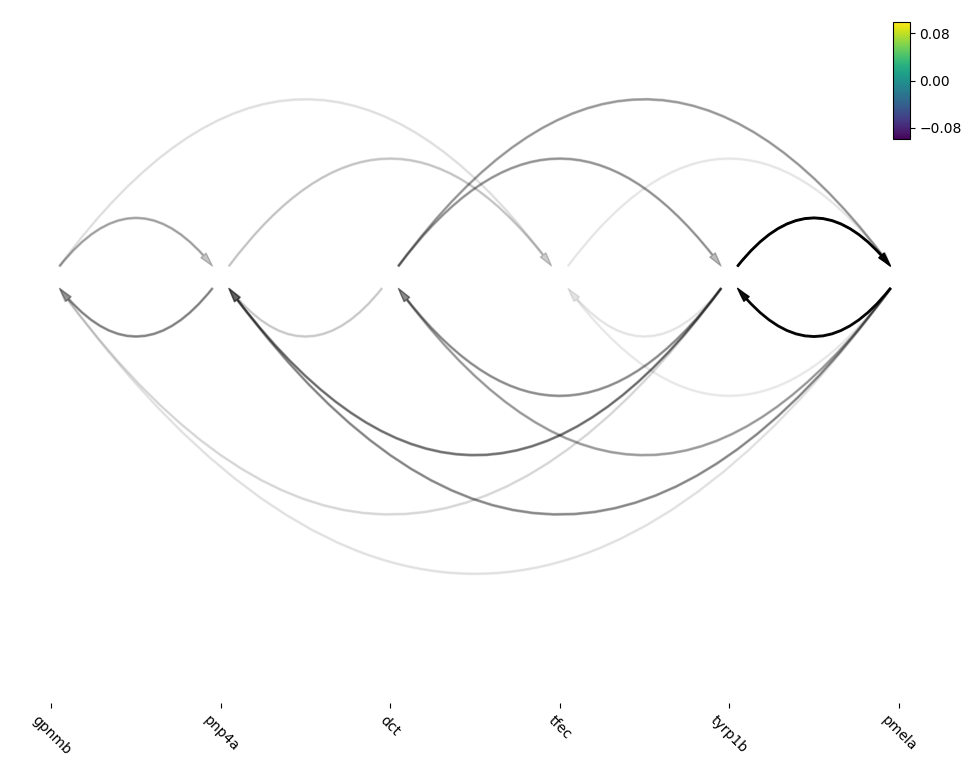

[12, 10, 10, 10, 12, 6]


<Figure size 640x480 with 0 Axes>

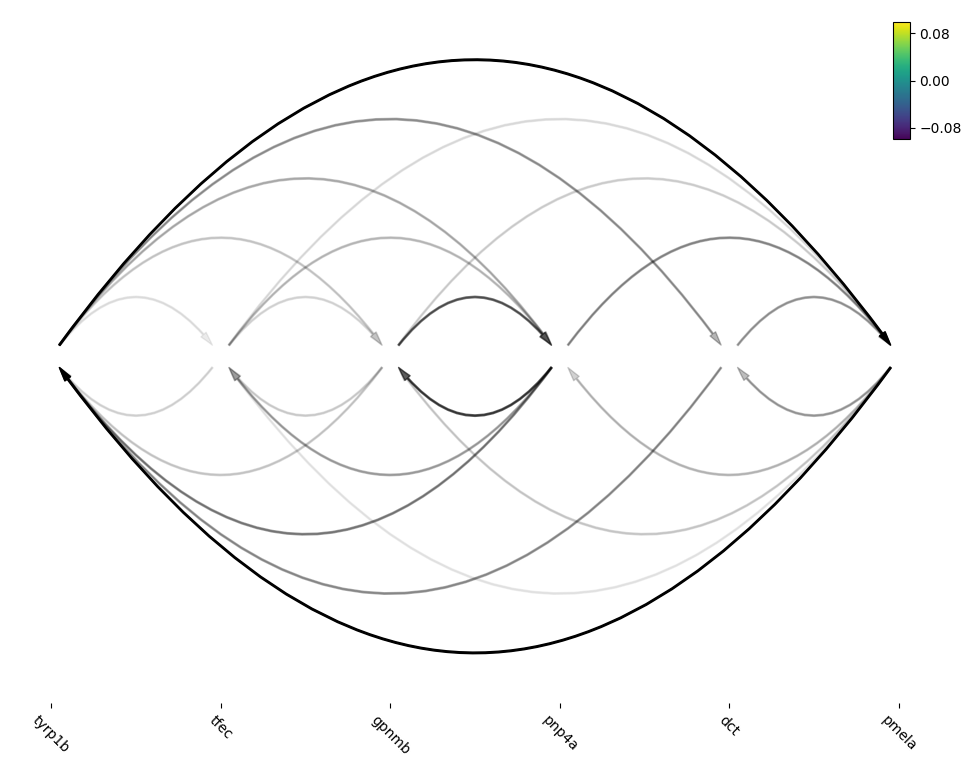

[12, 9, 10, 12, 12, 9]


<Figure size 640x480 with 0 Axes>

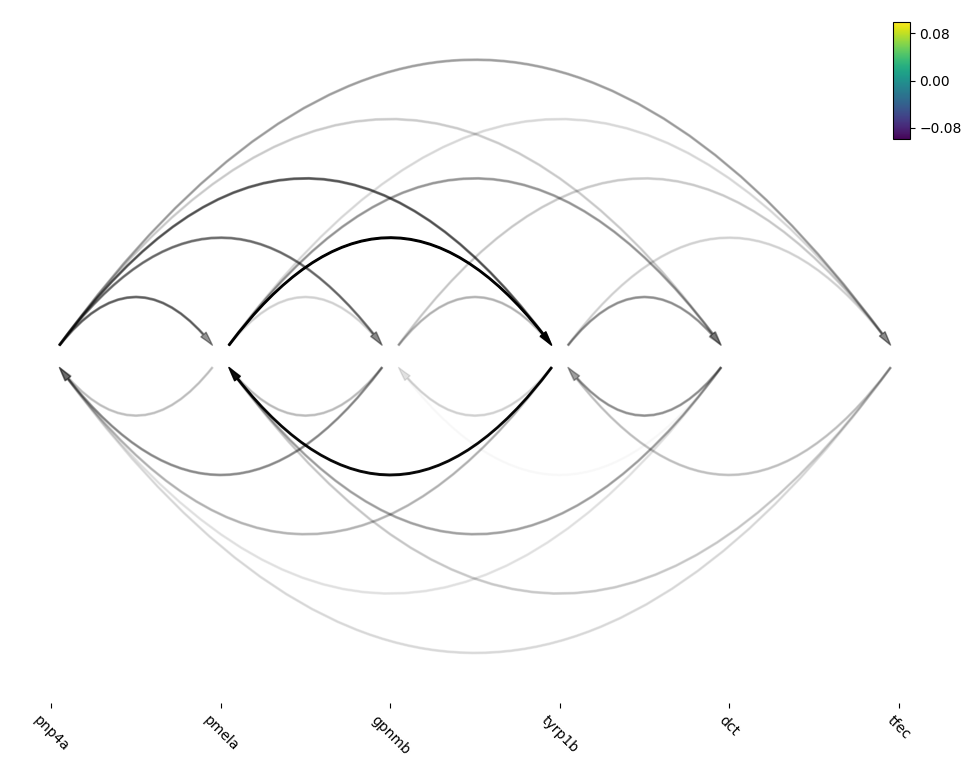

[9, 7, 11, 10, 11, 8]


<Figure size 640x480 with 0 Axes>

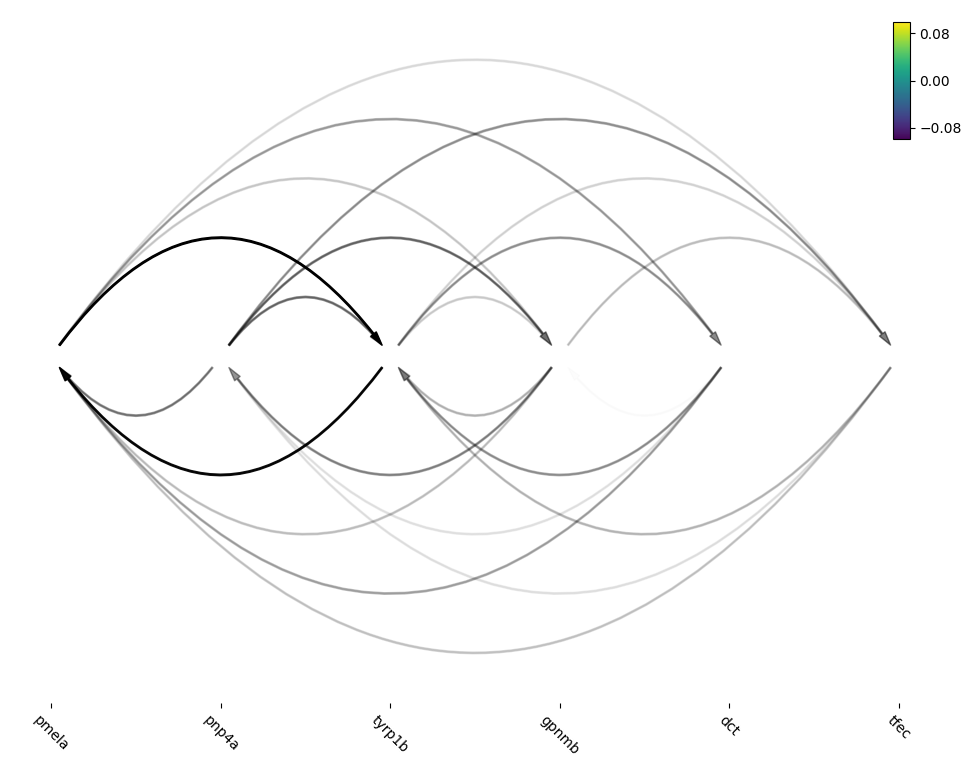

[12, 8, 12, 12, 10, 10]


<Figure size 640x480 with 0 Axes>

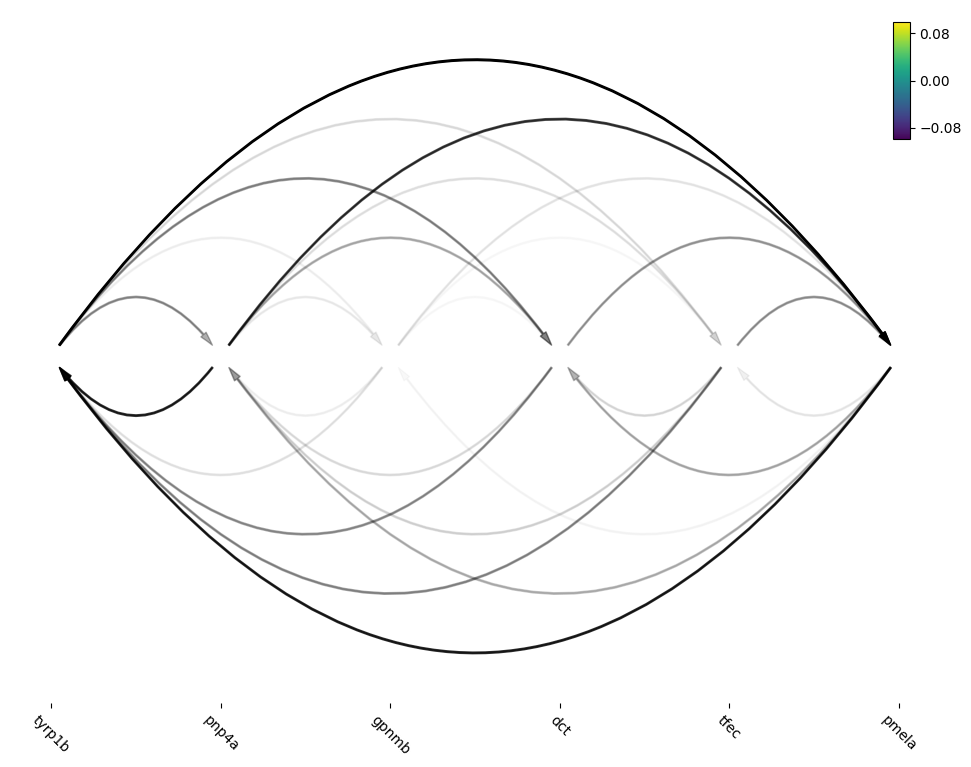

[12, 9, 10, 11, 11, 11]


<Figure size 640x480 with 0 Axes>

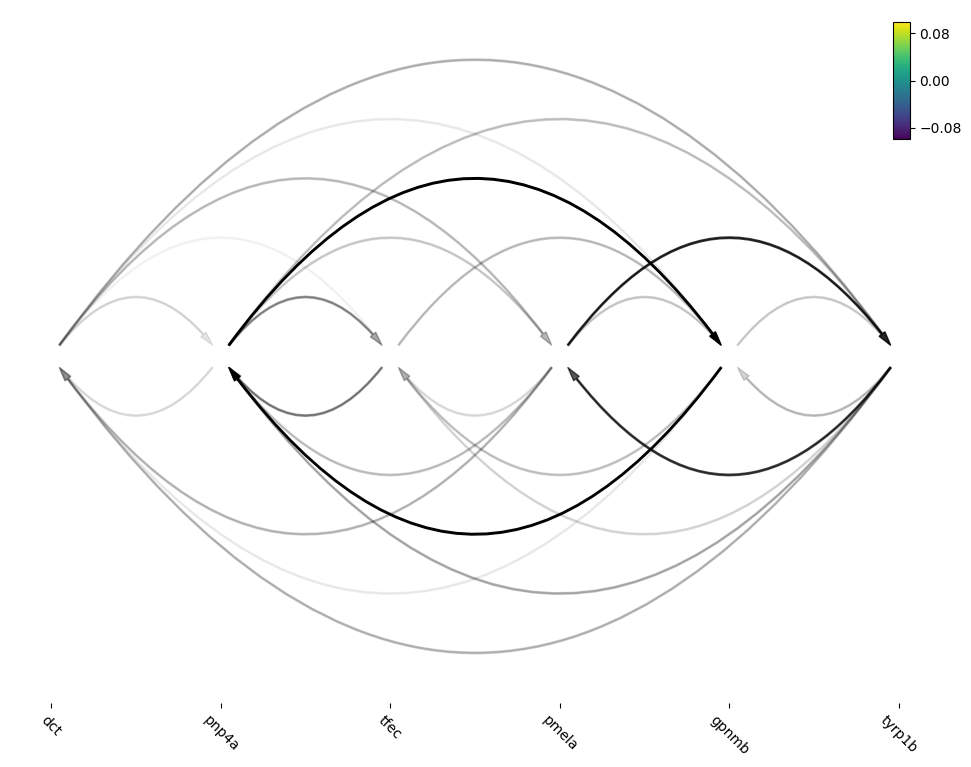

[12, 8, 10, 10, 12, 8]


<Figure size 640x480 with 0 Axes>

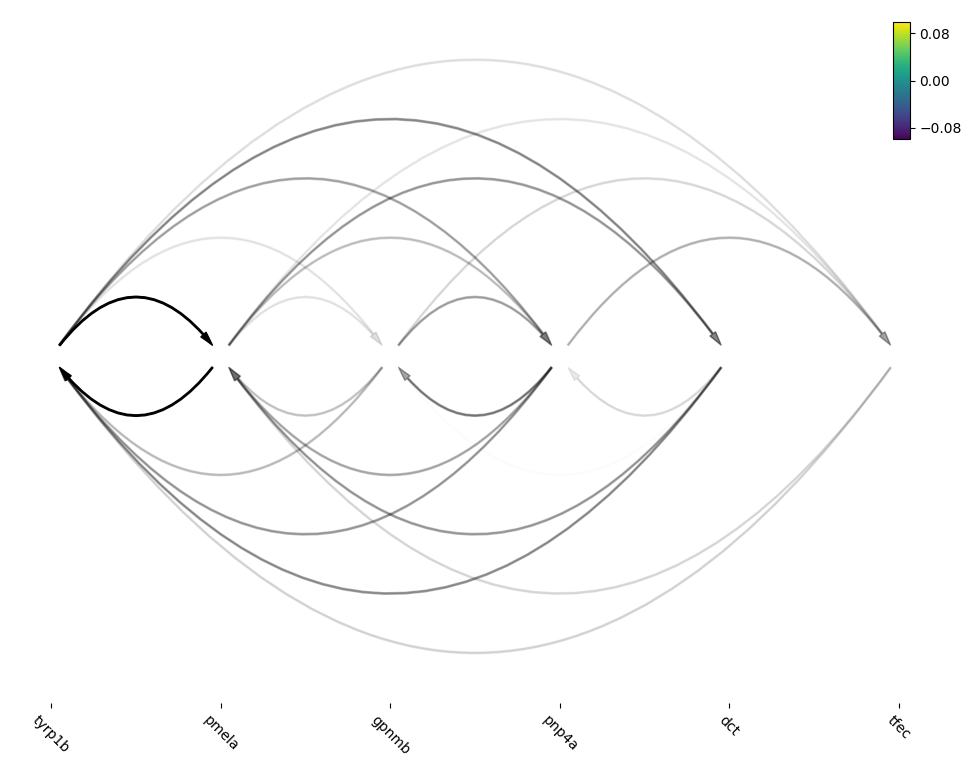

[11, 10, 11, 11, 12, 9]


<Figure size 640x480 with 0 Axes>

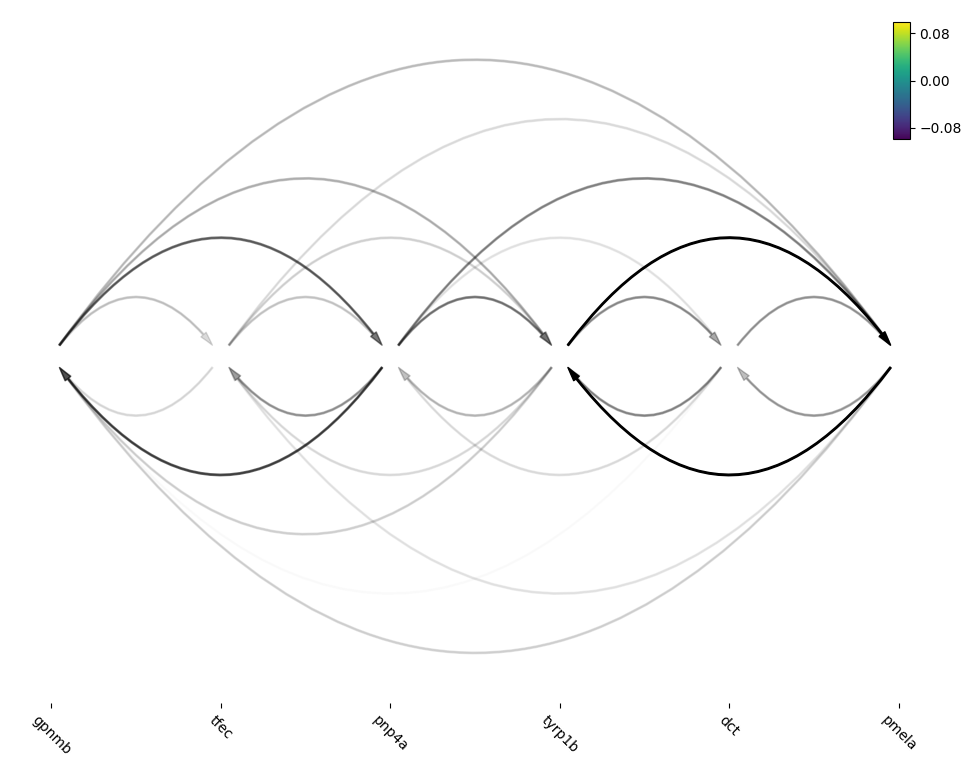

[11, 6, 11, 11, 7, 8]


<Figure size 640x480 with 0 Axes>

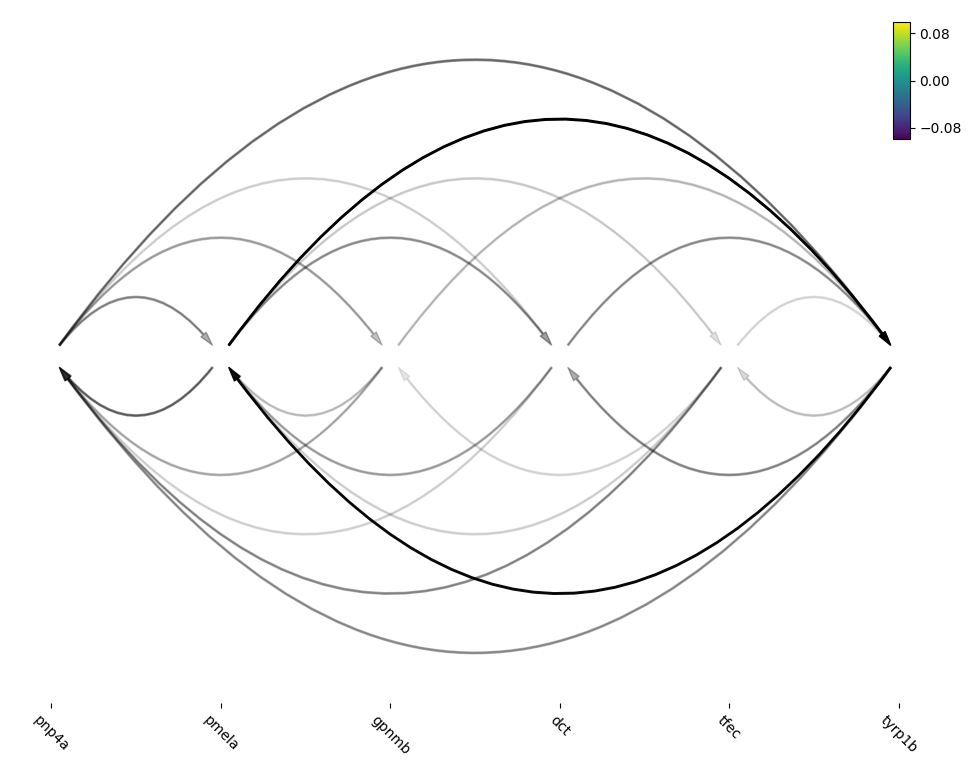

[11, 11, 10, 10, 12, 8]


<Figure size 640x480 with 0 Axes>

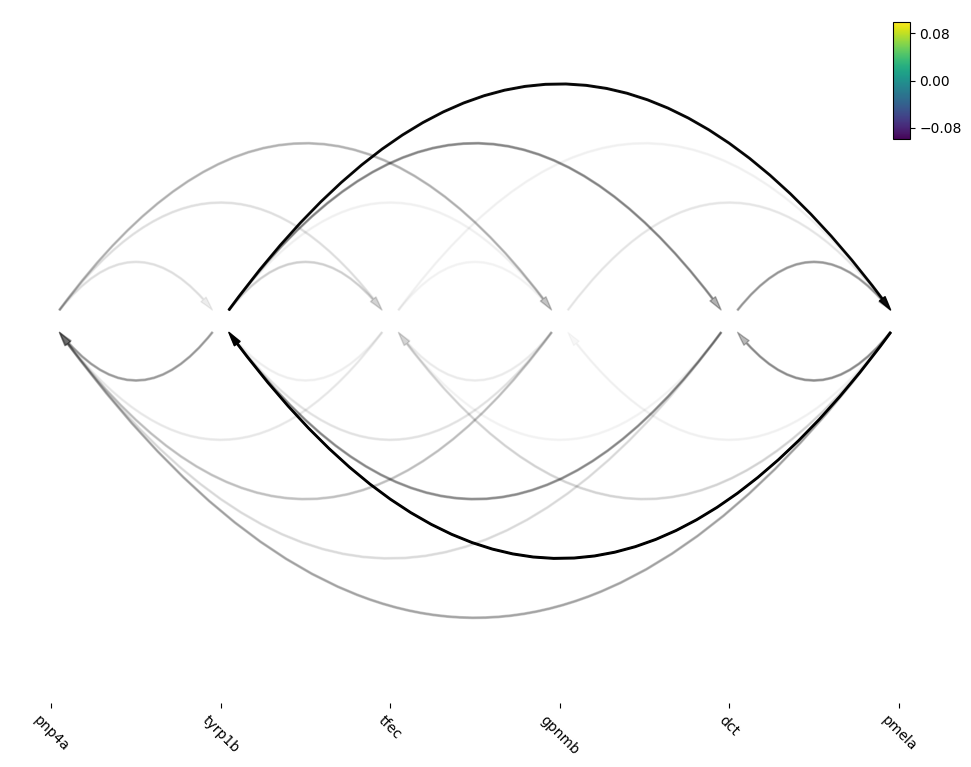

[11, 8, 10, 9, 11, 7]


<Figure size 640x480 with 0 Axes>

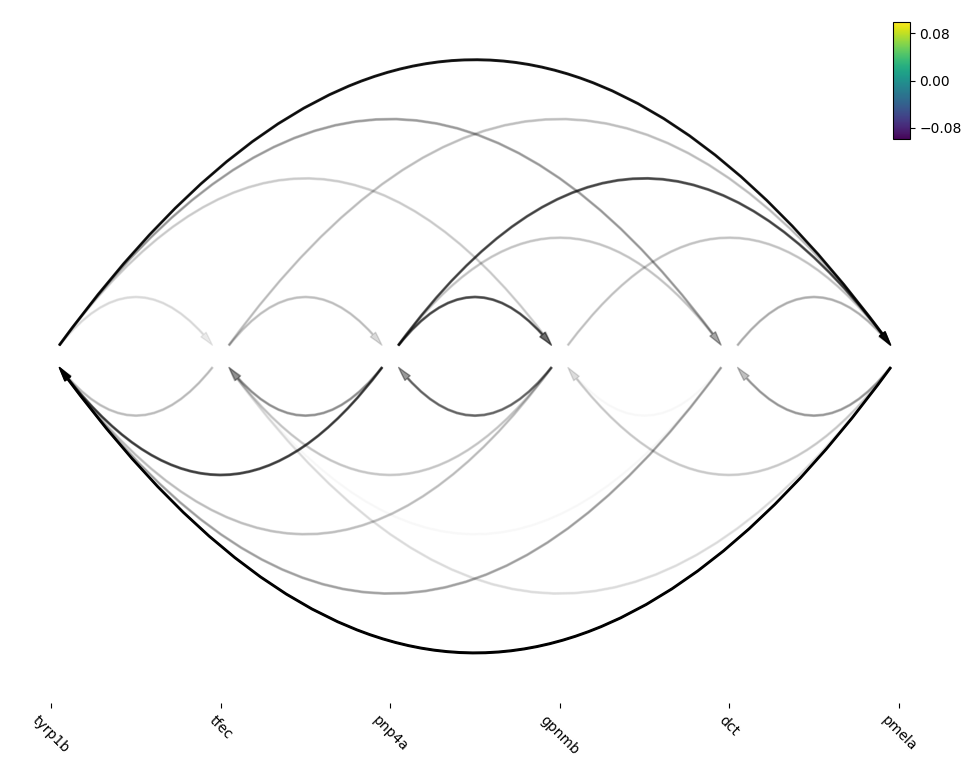

[12, 6, 8, 10, 12, 8]


<Figure size 640x480 with 0 Axes>

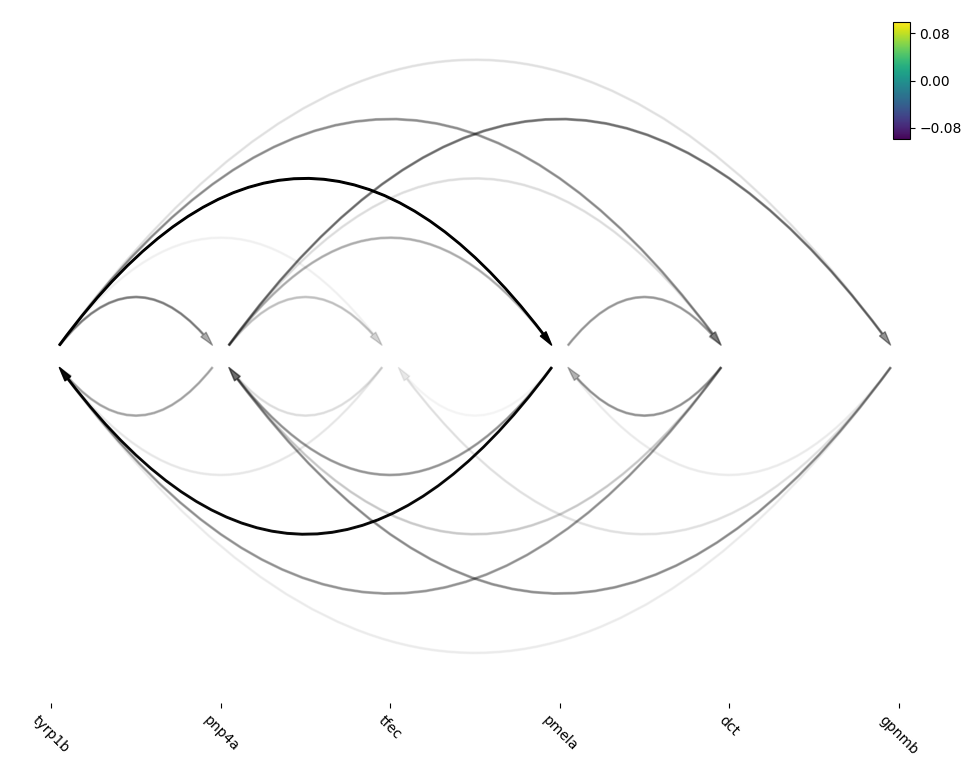

<Figure size 640x480 with 0 Axes>

In [28]:
# temp_genes = ["dct",  "tyrp1b"]
# print(list(edges_list.items())[0])
# edges_list = list(edges_list.items())[0]
# print(edges_list)
for i, name in enumerate(edges_list):
    network = nx.from_pandas_edgelist(edges_list[name].drop_duplicates().query("weight > 1e-5"), 'regulator', 'target', edge_attr='weight', create_using=nx.DiGraph())
    ax=dyn.pl.arcPlot(adata, cluster="Cell_type", cluster_name="base", edges_list=None, network=network, color="M_s", figsize=(12, 9), save_show_or_return='show')
    plt.savefig('./Cell_type_' + str(i) + '.pdf')

index
TGCCAAATCACCACCT-1-0                Schwann Cell
AAATGCCAGGAGCGTT-1-0                     Unknown
CAGCGACAGAGAACAG-1-0                Schwann Cell
GGGACCTGTGACCAAG-1-0                     Unknown
TCCCGATAGTGTGGCA-1-0                Schwann Cell
                                  ...           
TAGACCAAGTCCATAC-1-1                  Chromaffin
GGTGTTAAGGAATCGC-1-1                 Xanthophore
CTACCCAAGTGACATA-1-1    Proliferating Progenitor
TACTCATGTTACGCGC-1-1    Proliferating Progenitor
TCAACGACACTCTGTC-1-1                      Neuron
Name: Cell_type, Length: 4181, dtype: category
Categories (12, object): ['Chromaffin', 'Iridophore', 'Melanophore', 'Neuron', ..., 'Schwann Cell', 'Schwann Cell Precursor', 'Unknown', 'Xanthophore']


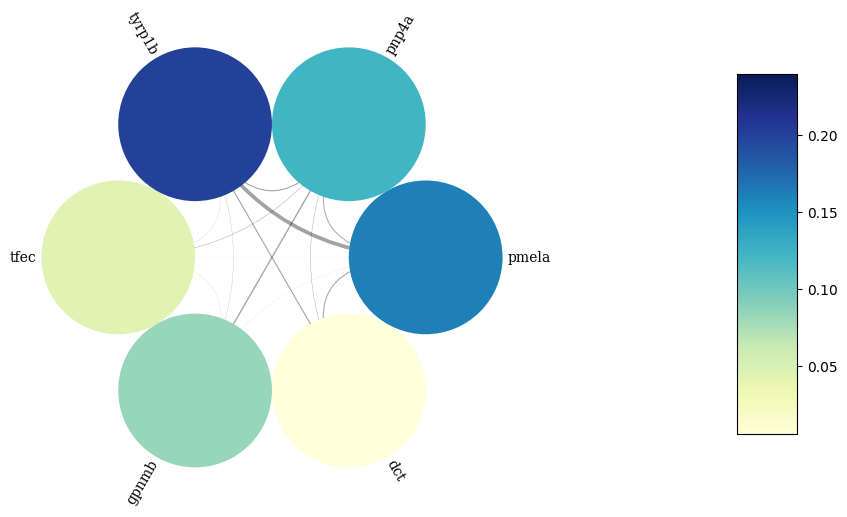

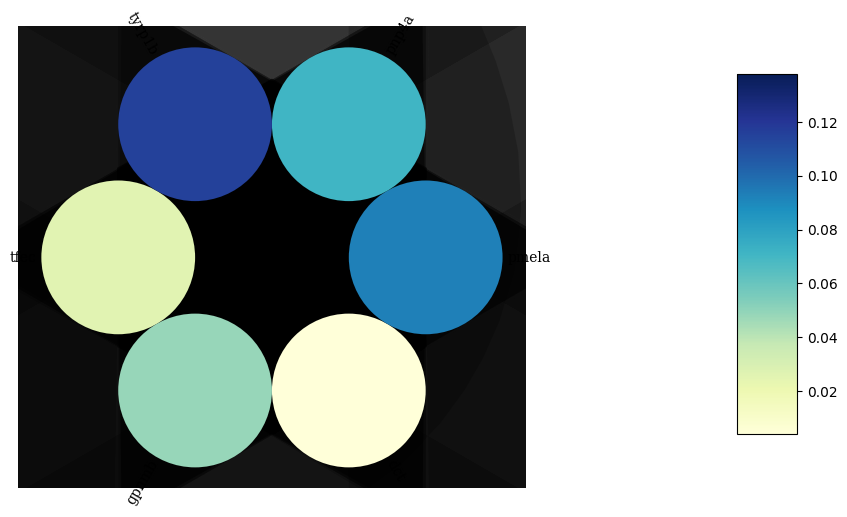

In [29]:
print(adata.obs.Cell_type)
dyn.pl.circosPlot(adata, cluster="Cell_type", cluster_name="Schwann Cell", edges_list=None, 
                  network=network, color="M_s", )
dyn.pl.circosPlot(adata, cluster="Cell_type", cluster_name="Unknown", edges_list=None, 
                  network=network, color="M_s", )

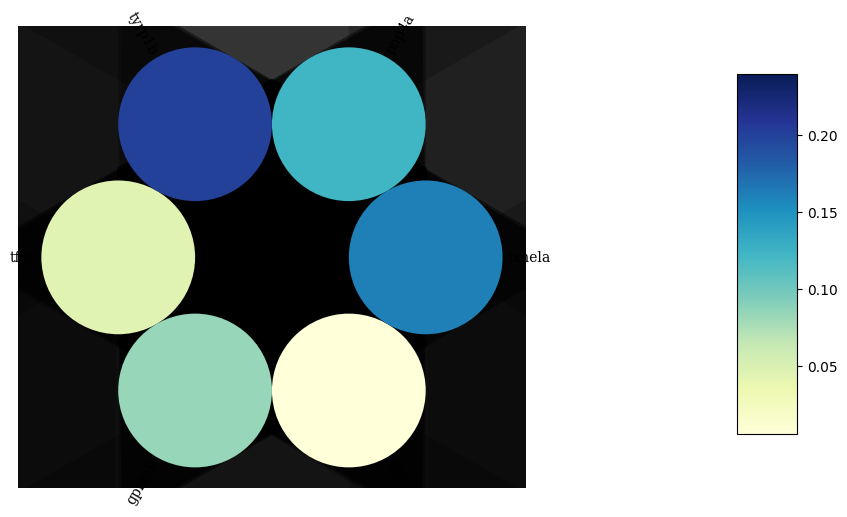

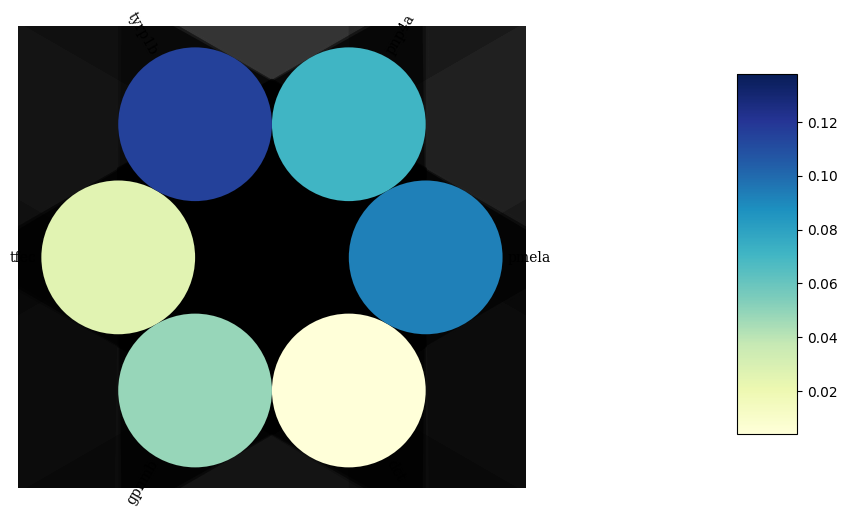

In [30]:
dyn.pl.circosPlot(adata, cluster="Cell_type", cluster_name="Schwann Cell", edges_list=None, 
                  network=network, color="M_s", )
dyn.pl.circosPlot(adata, cluster="Cell_type", cluster_name="Unknown", edges_list=None, 
                  network=network, color="M_s", )

In [31]:
rank_acceleration = adata.uns['rank_acceleration']
np.unique(rank_acceleration.head(25).values)

array(['CRIP2', 'IFI', 'MREG', 'ak1', 'akap12a', 'anxa13l', 'anxa4',
       'aqp1a.1', 'arl6ip1', 'atp1b1a', 'cadm4', 'calm2a', 'calm2b',
       'cd63', 'cdk1', 'cdkn1bb', 'cirbpa', 'cldn19', 'col4a1', 'cotl1',
       'crip1', 'cx27.5', 'dct', 'dynll1', 'egr2b', 'elovl1a', 'elovl1b',
       'entpd3', 'fhl2a', 'fosab', 'fosb', 'foxp4', 'fxyd1', 'gapdhs',
       'gch2', 'gldn', 'gpr143', 'grasp', 'gstp1', 'h2afvb', 'h3f3b.1',
       'hapln1a', 'hmga1a', 'hmgb1a', 'hmgb2a', 'krt18', 'lgals2a',
       'mdh1aa', 'mdka', 'mlpha', 'mt2', 'myo10l3', 'myo1cb', 'nfasca',
       'nr4a2b', 'oca2', 'p4hb', 'pcna', 'pfn2', 'phlda2', 'plp1b',
       'pmela', 'pmp22a', 'pmp22b', 'pnp4a', 'pnp5a', 'ptmaa', 'ptmab',
       'pvalb1', 'qdpra', 'qki2', 'qkia', 'rap1b', 'rasgef1ba', 'rbm24a',
       'rpl36a', 'rpl38', 'rplp2l', 'rrm2', 'rtn1b', 'sdc4', 'selt2',
       'si:ch211-132g1.3', 'si:ch211-137a8.4', 'si:ch211-156j16.1',
       'si:ch211-202a12.4', 'si:ch211-222l21.1', 'si:ch211-243a20.3',
       'si

In [32]:
edges_list[list(edges_list.keys())[0]]
edge_list = edges_list[list(edges_list.keys())[0]]

In [33]:
# edges_list = dyn.vf.build_network_per_cluster(adata,
#                                               cluster='Cell_type',
#                                               cluster_names=None,
#                                               full_reg_rank=full_reg_rank,
#                                               full_eff_rank=full_eff_rank,
#                                               genes=np.unique(rank_acceleration.head(25).values),
#                                               n_top_genes=100)

# network = nx.from_pandas_edgelist(edge_list.drop_duplicates().query("weight > 1e-5"), 'regulator', 'target', edge_attr='weight', create_using=nx.DiGraph())

# dyn.pl.circosPlot(adata, cluster="Cell_type", cluster_name='Unknown', edges_list=None, 
#                   network=network, color="M_s", weight_threshold=1e-5, weight_scale=5)

/Users/mashiro/dynamo-release/dynamo/plot/utils.py:315: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("bwr"))
  cmap_.set_bad("lightgray")
/Users/mashiro/dynamo-release/dynamo/plot/vector_calculus.py:539: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


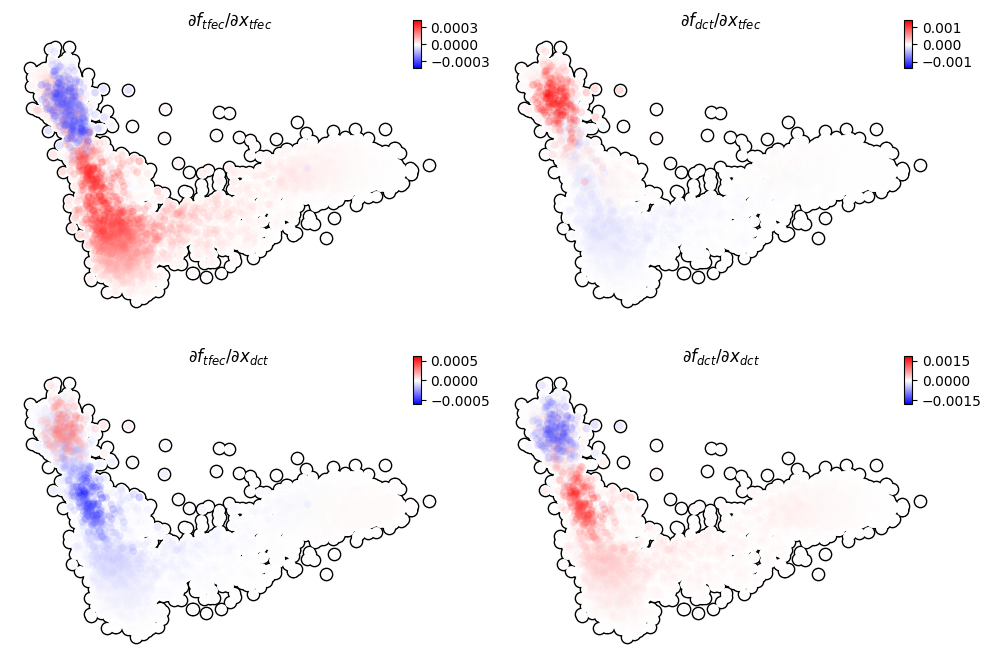

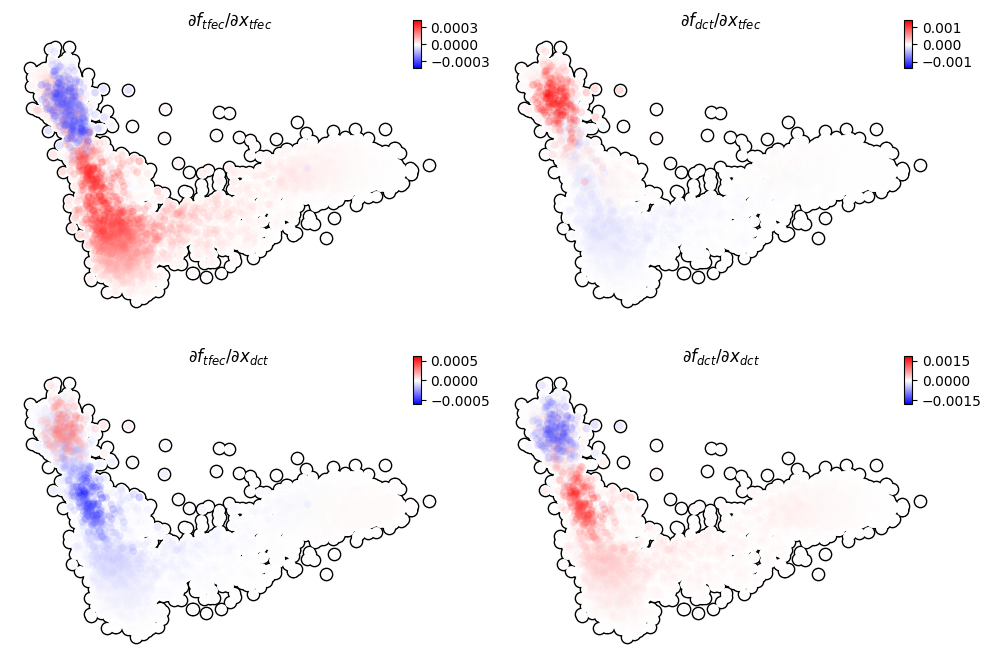

In [34]:
# dyn.pl.jacobian(adata, regulators=all_genes[:4], effectors=all_genes[:4], basis='pca_corrected')
dyn.pl.jacobian(adata, regulators=all_genes[:4], effectors=all_genes[:4], basis='pca')
dyn.pl.jacobian(adata, regulators=all_genes[:4], effectors=all_genes[:4], basis='pca')

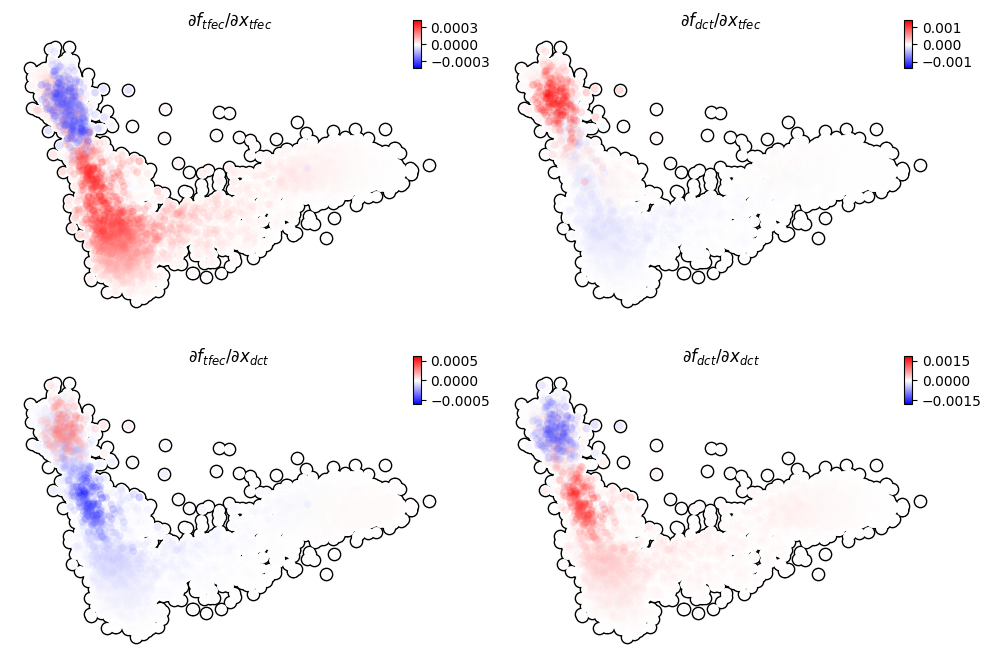

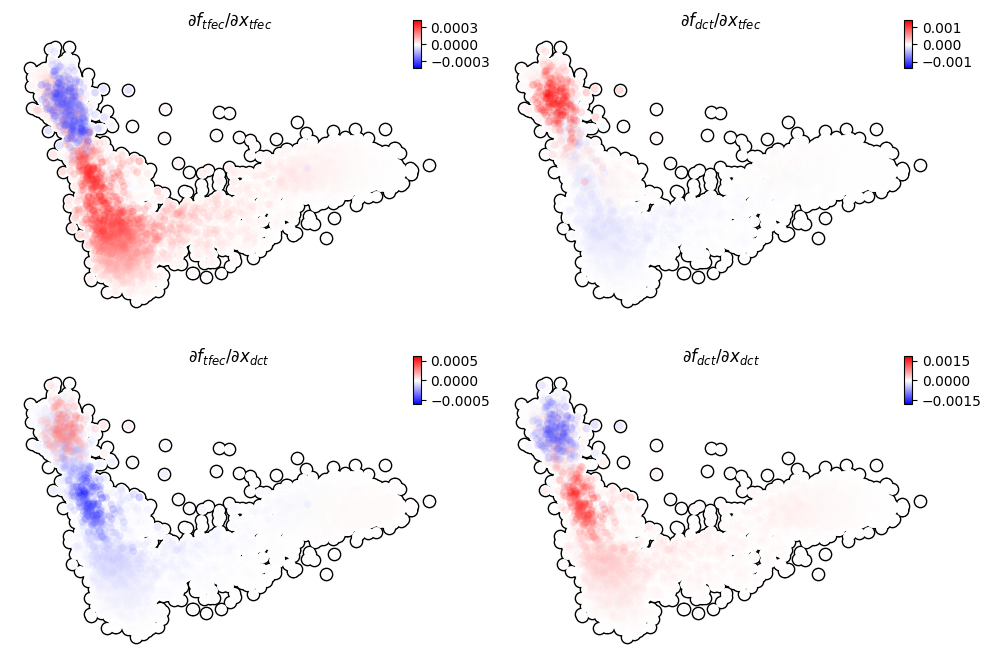

In [35]:
# dyn.pl.jacobian(adata, regulators=all_genes[:4], effectors=all_genes[:4], basis='pca_corrected', layer='M_s')
dyn.pl.jacobian(adata, regulators=all_genes[:4], effectors=all_genes[:4], basis='pca', layer='M_s')
dyn.pl.jacobian(adata, regulators=all_genes[:4], effectors=all_genes[:4], basis='pca', layer='M_s')


In [36]:
# print(dyn.ext.enrichr.get_library_name())
rank_abs_acceleration = adata.uns['rank_abs_acceleration']
enr = dyn.ext.enrichr(list(np.unique(rank_abs_acceleration.head(10).values)), 
                      organism='zebrafish', outdir='./enrichr', gene_sets='KEGG_2019', no_plot=True)
from gseapy.plot import barplot, dotplot

In [37]:
dyn.vf.rank_velocity_genes(adata)

AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'curvature_pca', 'acceleration_pca', 'jacobian_det_pca'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'use_for_pca', 'frac', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition', 'top_pca_genes'
    uns: 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_umap', 'grid_velocity_pca',

In [38]:
rank_speed = adata.uns['rank_velocity_S']

rank_speed.head(5)

all
0  rundc3aa
1       ntm
2     atp7a
3    zbtb46
4      KLHL

In [39]:
enr = dyn.ext.enrichr(list(rank_speed['all'].head(150)), organism='Fish', outdir='./enrichr', gene_sets='KEGG_2019', no_plot=True)

In [40]:
enr.results.head(5)

Gene_set                          Term Overlap   P-value  \
0  KEGG_2019       Glycerolipid metabolism    2/60  0.074601   
1  KEGG_2019   Basal transcription factors    1/40  0.260237   
2  KEGG_2019     mRNA surveillance pathway    2/88  0.141324   
3  KEGG_2019             Adherens junction    5/97  0.000822   
4  KEGG_2019  Steroid hormone biosynthesis    1/37  0.243307   

   Adjusted P-value  Old P-value  Old Adjusted P-value    Z-score  \
0          0.625091     0.060708              0.535215 -66.507536   
1          0.719479     0.234827              0.625272 -80.050209   
2          0.625091     0.115013              0.535215 -34.751968   
3          0.038629     0.000461              0.021648  -6.726862   
4          0.714715     0.219644              0.625272 -26.155294   

   Combined Score                                 Genes  
0      172.626842                         mboat2a;dgkza  
1      107.760514                                  taf6  
2       67.999137                         ppp2r3a;msi2b  
3       47.786957  mllt4a;tgfbr2b;ctnna2;sorbs1;baiap2a  
4       36.968698                              sult2st3

<AxesSubplot:title={'center':'top pca gene'}, xlabel='-log$_{10}$(Adjusted P-value)'>

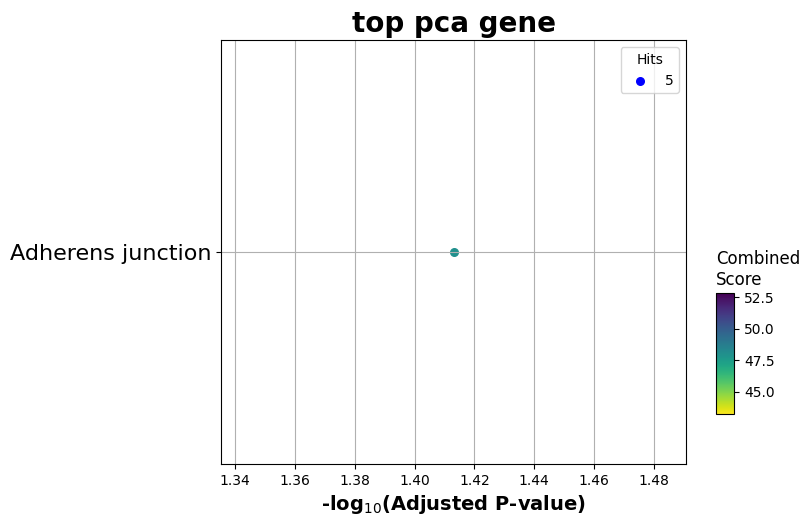

In [41]:
dotplot(enr.res2d, title='top pca gene', cmap='viridis_r')

In [42]:
dyn.ext.ddhodge(adata, basis='pca')

/Users/mashiro/anaconda3/envs/dynamo-dev/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Constructing diffusion graph from reconstructed vector field: 4181it [02:31, 27.51it/s]


/Users/mashiro/dynamo-release/dynamo/plot/utils.py:315: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap_.set_bad("lightgray")


<Figure size 600x400 with 0 Axes>

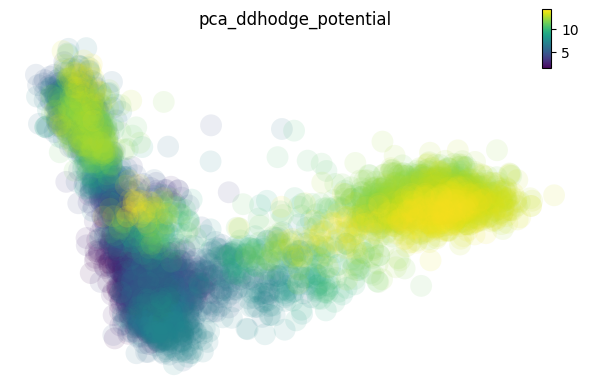

/Users/mashiro/dynamo-release/dynamo/plot/utils.py:315: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap_.set_bad("lightgray")


<Figure size 600x400 with 0 Axes>

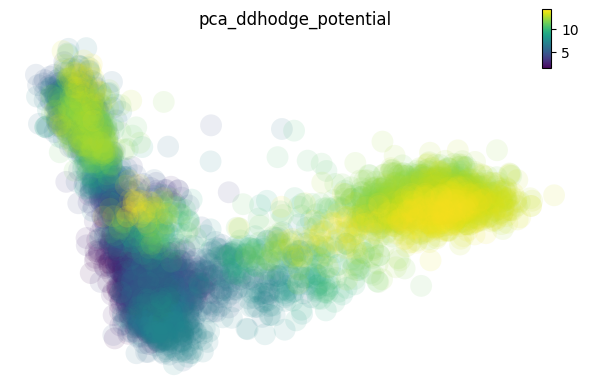

In [43]:
dyn.pl.scatters(adata, basis='pca', color='pca_ddhodge_potential')
dyn.pl.scatters(adata, basis='pca', color='pca_ddhodge_potential')

In [44]:
adata.obs.batch

index
TGCCAAATCACCACCT-1-0    0
AAATGCCAGGAGCGTT-1-0    0
CAGCGACAGAGAACAG-1-0    0
GGGACCTGTGACCAAG-1-0    0
TCCCGATAGTGTGGCA-1-0    0
                       ..
TAGACCAAGTCCATAC-1-1    1
GGTGTTAAGGAATCGC-1-1    1
CTACCCAAGTGACATA-1-1    1
TACTCATGTTACGCGC-1-1    1
TCAACGACACTCTGTC-1-1    1
Name: batch, Length: 4181, dtype: category
Categories (2, object): ['0', '1']

/Users/mashiro/anaconda3/envs/dynamo-dev/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


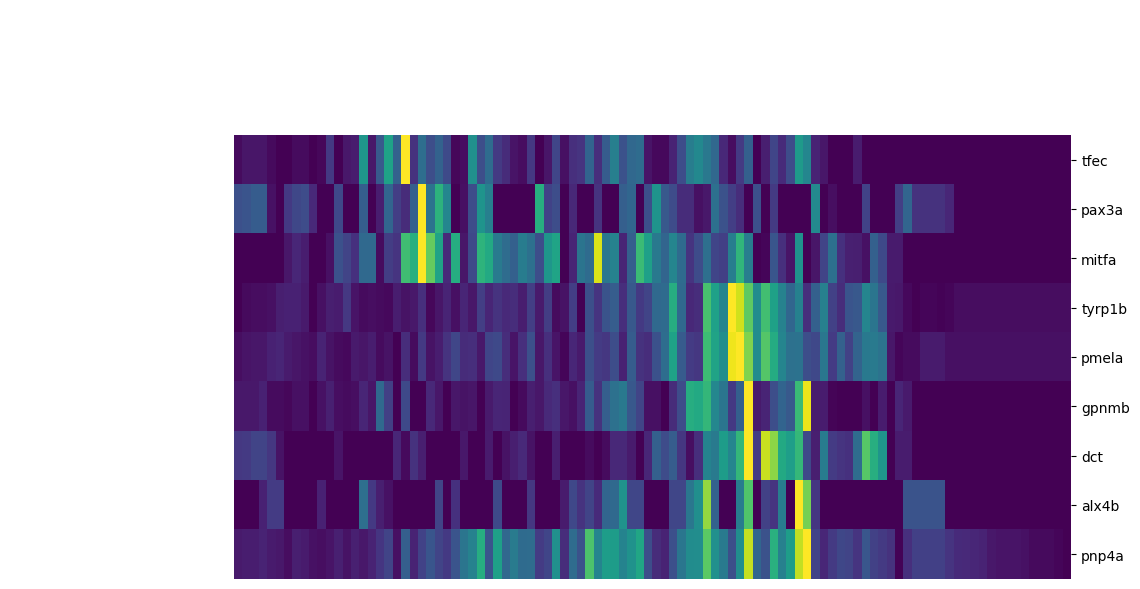

In [45]:
dyn.pl.kinetic_heatmap(adata[:, :], genes=all_genes, tkey='pca_ddhodge_potential',
                       gene_order_method='maximum', mode='pseudotime', color_map='viridis')

### Build state graphs of cell types or clusters.

Index(['TGCCAAATCACCACCT-1-0', 'AAATGCCAGGAGCGTT-1-0', 'CAGCGACAGAGAACAG-1-0',
       'GGGACCTGTGACCAAG-1-0', 'TCCCGATAGTGTGGCA-1-0', 'CAGAGAGAGGCGATAC-1-0',
       'AACTGGTAGTGGAGAA-1-0', 'ATTGGACGTCTAGCGC-1-0', 'TGGGCGTCACCAGGTC-1-0',
       'TTGGCAAAGGGCTTCC-1-0',
       ...
       'TGGACGCTCAAACAAG-1-1', 'GGGCATCCATATGGTC-1-1', 'CCTAAAGCAGATCGGA-1-1',
       'AAACCTGGTGTGTGCC-1-1', 'CGGACACCACGAGAGT-1-1', 'TAGACCAAGTCCATAC-1-1',
       'GGTGTTAAGGAATCGC-1-1', 'CTACCCAAGTGACATA-1-1', 'TACTCATGTTACGCGC-1-1',
       'TCAACGACACTCTGTC-1-1'],
      dtype='object', name='index', length=4181)


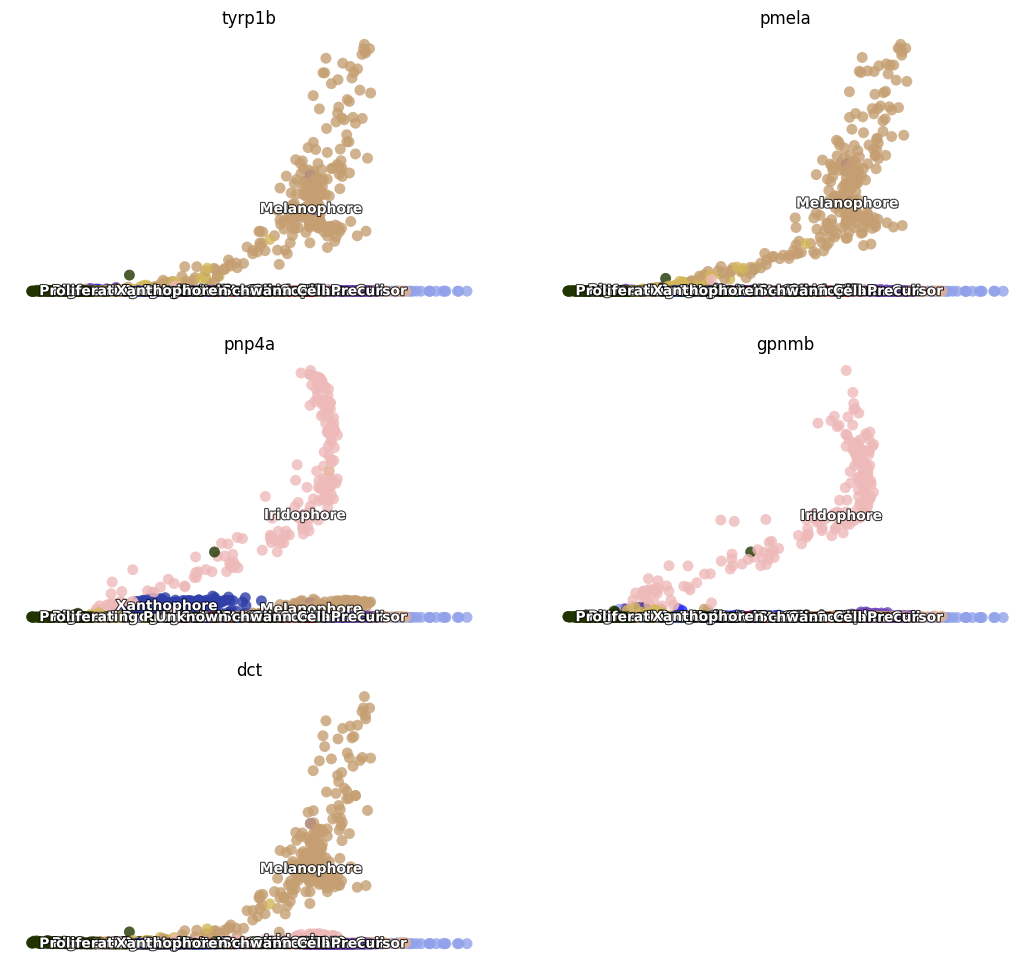

In [46]:
import numpy as np 
gene_names = ['tyrp1b', 'pmela', 'pnp4a', 'gpnmb', 'dct']
print(adata.obs.index)
dyn.pl.scatters(adata, x=np.repeat('pca_ddhodge_potential', 5), pointsize=0.25, alpha=0.8, 
                y=gene_names, layer='M_s', color='Cell_type',
                ncols=2, background='white', figsize=(7, 4))


In [47]:
adata.obs['ClusterStr'] = adata.obs['Cluster'].astype(str)

In [48]:
%%capture 

dyn.pd.state_graph(adata, group='Cell_type', basis='pca', method='vf')
dyn.pd.state_graph(adata, group='ClusterStr', basis='pca', method='vf')


|-----> KDTree computation finished [0.0058s]

|-----> KDTree computation finished [0.0018s]


/Users/mashiro/dynamo-release/dynamo/plot/state_graph.py:120: RuntimeWarning: invalid value encountered in true_divide
  Pl /= Pl.sum(1)[:, None]
/Users/mashiro/dynamo-release/dynamo/plot/utils.py:315: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap_.set_bad("lightgray")


<Figure size 640x480 with 0 Axes>

<Figure size 600x400 with 0 Axes>

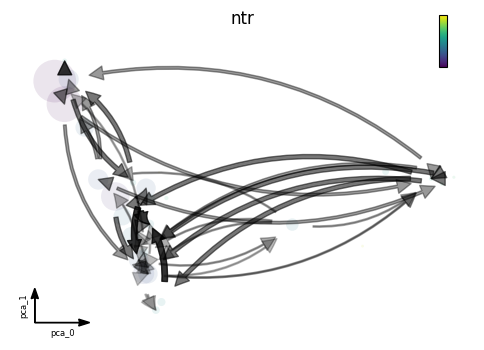

<Figure size 640x480 with 0 Axes>

In [49]:
dyn.pl.state_graph(adata, group='ClusterStr', basis='pca', method='vf')

/Users/mashiro/dynamo-release/dynamo/plot/state_graph.py:120: RuntimeWarning: invalid value encountered in true_divide
  Pl /= Pl.sum(1)[:, None]
/Users/mashiro/dynamo-release/dynamo/plot/utils.py:315: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap_.set_bad("lightgray")


<Figure size 640x480 with 0 Axes>

<Figure size 600x400 with 0 Axes>

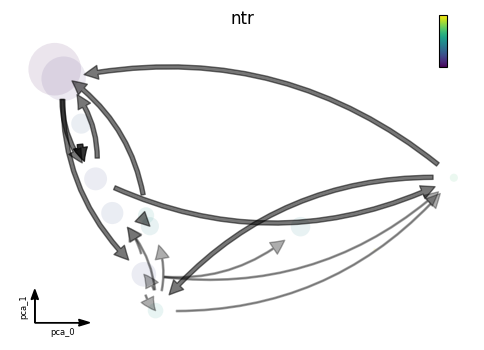

<Figure size 640x480 with 0 Axes>

In [50]:
dyn.pl.state_graph(adata, group='Cell_type', basis='pca', method='vf')